# MLP Classifier

#### Using the same flowers dataset

IMPORTING LIBRARIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
from timeit import default_timer as timer

LOADING DATASET

In [2]:

def load_dataset(base_path="C:\\Users\\belei\\Desktop\\SIM\\Big Data\\YEAR 2\\Y2 SEM 3\\218\\LAB\\flowers", img_size = 32):
    LABELS = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    X = []
    Y = []
    
    for label in LABELS:
        folder_path = os.path.join(base_path, label)
        print(f"Checking folder: '{folder_path}'")  # Debugging
        print(f"Exists? {os.path.exists(folder_path)}")  # Debugging

        # Skip missing folders
        if not os.path.exists(folder_path): 
            continue

        for img_name in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path) #loading the image
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            Y.append(label)

    #Convert lists to NumPy arrays
    X = np.array(X)
    Y = np.array(Y)  #Convert labels to numbers
    
    return X, Y

PREPROCESSING IMGES, LOADING IN DATASET, EXTRACTING COLOR HISTOGRAM

In [3]:
def preprocess_image(X, Y):
    #normalize the pixel values
    X = X / 255.0
    encoder = LabelEncoder()
    #converts target values to numerics
    Y = encoder.fit_transform(Y)
    return X, Y

DEFINING EXTRACTION OF COLOUR HISTOGRAM FEATURES FROM IMAGES TO USE FOR TRAINING IN MLP


In [4]:
def extract_color_histogram(X, hist_size=6):
    col_hist = []
    for img in X:
        #ensuring that input values are in RGB numerics
        if img is None:
            print("Found empty image")
            continue

        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
            
        hist = cv2.calcHist([img], [0, 1, 2], None, (hist_size, hist_size, hist_size), [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        col_hist.append(hist)
    return np.array(col_hist)

In [5]:
X, Y = load_dataset()
print(f"X shape: {X.shape}")  #Expected: (num_samples, num_features)
print(f"y shape: {Y.shape}")  #Expected: (num_samples,)'Loaded {len(X) - current_size} {LABELS[i]} images')

X, Y = preprocess_image(X, Y)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

X = extract_color_histogram(X)
print(f"Shape of Hist: {X.shape}")

Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\daisy'
Exists? True


100%|██████████| 764/764 [00:00<00:00, 1826.07it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\dandelion'
Exists? True


100%|██████████| 1052/1052 [00:00<00:00, 1747.95it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\rose'
Exists? True


100%|██████████| 784/784 [00:00<00:00, 1806.97it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\sunflower'
Exists? True


100%|██████████| 733/733 [00:00<00:00, 1357.68it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\tulip'
Exists? True


100%|██████████| 984/984 [00:00<00:00, 1600.29it/s]


X shape: (4317, 32, 32, 3)
y shape: (4317,)
Shape of X: (4317, 32, 32, 3)
Shape of Y: (4317,)
Shape of Hist: (4317, 216)


DEFINING MLP STRUCTURE

In [6]:
input_size = 32*32*3
output_size = 5
m = int((2/3) * input_size + output_size)
print(f"Computed m: {m}")

mlp_structures = {
    1: (m,),                       
    2: (int(m * 0.75),),            
    3: (int(m * 0.5),),             
    4: (m, int(m * 0.5)),           
    5: (m, int(m * 0.75)),          
    6: (int(m * 0.75), int(m * 0.5)),
    7: (m, int(m * 0.75), int(m * 0.5)),  
    8: (m, int(m * 0.5), int(m * 0.25)),  
    9: (int(m * 0.75), int(m * 0.5), int(m * 0.25))  
}

for i in range(1, 10):
    print(f"MLP Structure {i}: {mlp_structures[i]}")

mlp_structures = list(mlp_structures.values())


Computed m: 2053
MLP Structure 1: (2053,)
MLP Structure 2: (1539,)
MLP Structure 3: (1026,)
MLP Structure 4: (2053, 1026)
MLP Structure 5: (2053, 1539)
MLP Structure 6: (1539, 1026)
MLP Structure 7: (2053, 1539, 1026)
MLP Structure 8: (2053, 1026, 513)
MLP Structure 9: (1539, 1026, 513)


SPLITTING INTO TRAINING, VALIDATON AND TESTING

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (2590, 216), (2590,)
Validation set: (863, 216), (863,)
Test set: (864, 216), (864,)


STEP 6: TRAINING MLP CLASSIFIER WITH OPTIMAL STRUCTURE

In [8]:

best_acc = 0
best_config = None
training_times = {}

for config in mlp_structures:
    print(f"\nTraining MLP with hidden layer structure: {config}...")

    start_time = timer() #starts timing

    mlp = MLPClassifier(hidden_layer_sizes=config,
                        max_iter=1000,
                        learning_rate_init=0.001, 
                        random_state=1).fit(X_train, y_train)
   
    training_time = timer() - start_time        #cacluclates the training time
    training_times[config] = training_time       #store training time

    y_pred = mlp.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    print(f"Validation Accuracy: {acc: .4f} \nTraining Time: {training_times[config]: .4f} seconds")

    if acc > best_acc:
        best_acc = acc
        best_config = config

    print(f"\nBest MLP Configuration: {best_config} with Accuracy: {best_acc:.4f}")


Training MLP with hidden layer structure: (2053,)...
Validation Accuracy:  0.5968 
Training Time:  71.5616 seconds

Best MLP Configuration: (2053,) with Accuracy: 0.5968

Training MLP with hidden layer structure: (1539,)...
Validation Accuracy:  0.5921 
Training Time:  52.8105 seconds

Best MLP Configuration: (2053,) with Accuracy: 0.5968

Training MLP with hidden layer structure: (1026,)...
Validation Accuracy:  0.5805 
Training Time:  27.6416 seconds

Best MLP Configuration: (2053,) with Accuracy: 0.5968

Training MLP with hidden layer structure: (2053, 1026)...
Validation Accuracy:  0.5852 
Training Time:  89.1754 seconds

Best MLP Configuration: (2053,) with Accuracy: 0.5968

Training MLP with hidden layer structure: (2053, 1539)...
Validation Accuracy:  0.6002 
Training Time:  94.0578 seconds

Best MLP Configuration: (2053, 1539) with Accuracy: 0.6002

Training MLP with hidden layer structure: (1539, 1026)...
Validation Accuracy:  0.5805 
Training Time:  69.7392 seconds

Best MLP

RETRAINING MLP MODEL WITH BEST CONFIGURATION

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time

#Start train time timer
start_train_time = time.time()
#Re-train the best model on the full training + validation data
mlp_best = MLPClassifier(hidden_layer_sizes=best_config, 
                        max_iter=1000, 
                        learning_rate_init=0.001, 
                        random_state=1)
mlp_best.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))  # Merge train + val

#Compute total training time
training_time = time.time() - start_train_time

#Start inference timer
start_inference_time = time.time()
y_pred_test = mlp_best.predict(X_test)
inference_time = time.time() - start_inference_time

#Compute classification metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

#Print Results
print(f"\n Test Set Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Inference Time: {inference_time:.4f} seconds")

#Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))



 Test Set Evaluation Results:
Accuracy: 0.6100
Precision: 0.6194
Recall: 0.6100
F1 Score: 0.6104
Training Time: 124.8962 seconds
Inference Time: 0.0210 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       167
           1       0.67      0.55      0.61       215
           2       0.51      0.49      0.50       162
           3       0.76      0.70      0.73       141
           4       0.53      0.71      0.61       179

    accuracy                           0.61       864
   macro avg       0.62      0.61      0.61       864
weighted avg       0.62      0.61      0.61       864



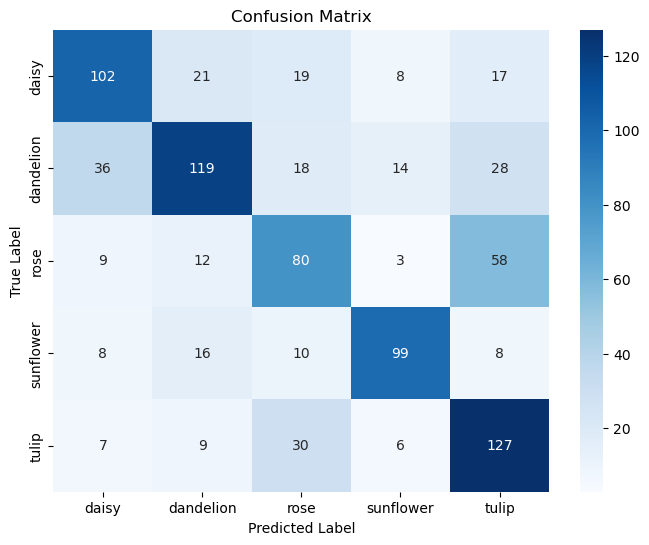


 Most Confused Classes: rose <-> tulip


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

LABELS = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

#Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#Find most confused classes
conf_matrix_no_diagonal = conf_matrix.copy()
np.fill_diagonal(conf_matrix_no_diagonal, 0)  # Remove correct classifications
most_confused = np.unravel_index(np.argmax(conf_matrix_no_diagonal), conf_matrix_no_diagonal.shape)

print(f"\n Most Confused Classes: {LABELS[most_confused[0]]} <-> {LABELS[most_confused[1]]}")


In [11]:
correct_indices = np.where(y_pred_test == y_test)[0]
wrong_indices = np.where(y_pred_test != y_test)[0]

print(f"\nCorrectly Classified: {len(correct_indices)} images")
print(f"Wrongly Classified: {len(wrong_indices)} images")



Correctly Classified: 527 images
Wrongly Classified: 337 images


In [12]:
#reloading original imagines
X_original, Y_original = load_dataset()

#resplitting before feature extraction to check correctly classified images
#Recreate the train, validation, and test sets
X_train_original, X_temp, y_train_original, y_temp = train_test_split(X_original, Y_original, test_size=0.4, random_state=42)
X_val_original, X_test_original, y_val_original, y_test_original = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\daisy'
Exists? True


100%|██████████| 764/764 [00:00<00:00, 1906.52it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\dandelion'
Exists? True


100%|██████████| 1052/1052 [00:00<00:00, 1770.41it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\rose'
Exists? True


100%|██████████| 784/784 [00:00<00:00, 1729.99it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\sunflower'
Exists? True


100%|██████████| 733/733 [00:00<00:00, 1353.54it/s]


Checking folder: 'C:\Users\belei\Desktop\SIM\Big Data\YEAR 2\Y2 SEM 3\218\LAB\flowers\tulip'
Exists? True


100%|██████████| 984/984 [00:00<00:00, 1587.96it/s]


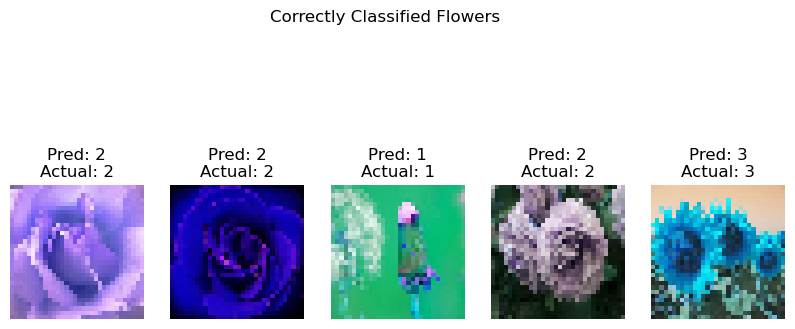

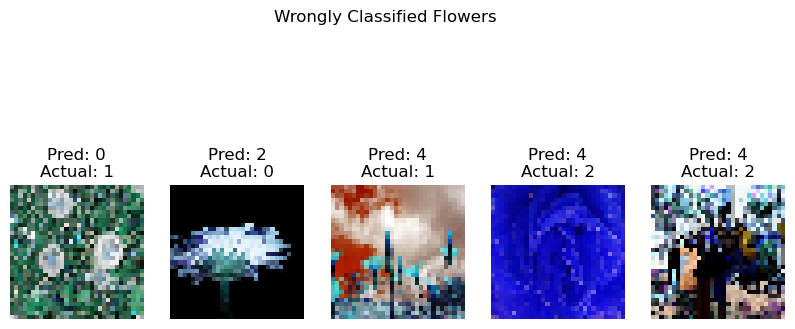

In [13]:
import matplotlib.pyplot as plt

def show_images(indices, title, num_images=5):
    plt.figure(figsize=(10, 5))

    if len(indices) == 0:
        print("No images found to display!")
        return

    for i, idx in enumerate(indices[:num_images]):
        img_size = 32  # Match dataset size

        if idx >= len(X_test_original):
            print(f"Skipping index {idx} (out of range)")
            continue

        img = X_test_original[idx]

        #Ensure correct shape (if X_test is flattened)
        if len(img.shape) == 1:
            img = img.reshape(img_size, img_size, 3)

        #Ensure image values are in correct range
        img = (img * 255).astype("uint8") if img.max() <= 1 else img

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {y_pred_test[idx]}\nActual: {y_test[idx]}")
    
    plt.suptitle(title)
    plt.show()

# Show Correctly Classified Images
show_images(correct_indices, "Correctly Classified Flowers")

# Show Incorrectly Classified Images
show_images(wrong_indices, "Wrongly Classified Flowers")
